In [1]:
%matplotlib inline

from datetime import datetime as dt
from math import sqrt
import pickle
from random import sample

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import holtwinters as hw

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None

In [2]:
bo_open_df = pd.read_csv('./bo_open_ts.csv')
bo_open_df = bo_open_df.loc[
    bo_open_df.year >= 2010
]
bo_open_df.dropna(inplace=True)

sums_df = bo_open_df.groupby(['year', 'month'], as_index=False).sum()
sums_df.drop('week', axis=1, inplace=True)

bo_sums = list(sums_df.opening_weekend_gross)

#### HW month sum BO forecast.

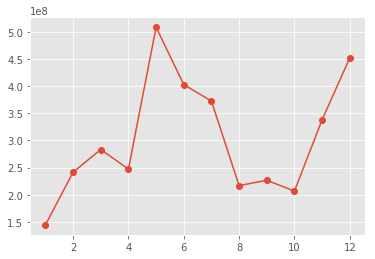

In [3]:
def get_hw_forecast(year, month, lookback=36):
    ix = sums_df.loc[
        (sums_df.year == year) &
        (sums_df.month == month)
    ].index[0]
    
    if ix >= lookback:
        start_ix = ix - lookback
    else:
        start_ix = 0

    bo_opens = list(sums_df.iloc[start_ix:ix].opening_weekend_gross)

    hw_forecast = hw.additive(bo_opens, 12, 1)
    hw_fc = hw_forecast[0]
    rmse = hw_forecast[-1]

    return hw_fc[0], rmse

fcs = [get_hw_forecast(2016, month)[0] for month in range(1, 13)]
plt.plot(range(1, 13), fcs, marker='o')

#### Get lr seasonal corrections.

In [4]:
nrg_bom_df = pd.read_csv('./nrg_bom_df.p')
nrg_bom_df['def/pos'] = nrg_bom_df.definite_int / nrg_bom_df.positive_int
nrg_bom_df['def/pos_sq'] = nrg_bom_df['def/pos'] * nrg_bom_df['def/pos']

lr_predictor_columns = [
    'unaided_intent',
    'first_choice',
    'def/pos',
    'def/pos_sq'
]
target_column = 'opening_weekend_gross'

In [5]:
lr_residual = pickle.load(open('./lr_residual.p', 'rb'))

def get_residual_prediction(date_str):
    date = dt.strptime(date_str, '%Y-%m-%d')
    year = date.year
    month = date.month
    if month in [5, 6, 7, 11, 12]:
        return 0
    bo_forecast = get_hw_forecast(year, month)[0]
    residual_forecast = lr_residual.predict([[bo_forecast, ]])[0]
    return residual_forecast

nrg_bom_df['residual_prediction'] = nrg_bom_df.release_date.apply(get_residual_prediction)

Train/test split.

In [6]:
N = nrg_bom_df.index.size
TEST_SIZE = round(N * .25)

test_ixs = sample(list(range(N)), TEST_SIZE)
train_ixs = list(set(range(N)) - set(test_ixs))

train_df = nrg_bom_df.iloc[train_ixs]
test_df = nrg_bom_df.iloc[test_ixs]

X_train_lr = train_df.loc[:, lr_predictor_columns].values
X_test_lr = test_df.loc[:, lr_predictor_columns].values

y_train = train_df.loc[:, target_column].values
y_test = test_df.loc[:, target_column].values

# IY. Issue here!
# X_lr = np.concatenate((X_train_lr, X_test_lr))
# y = np.concatenate((y_train, y_test))

X_lr = nrg_bom_df.loc[:, lr_predictor_columns].values
y = nrg_bom_df.loc[:, target_column].values

In [7]:
lr = LinearRegression()
lr.fit(X_train_lr, y_train)

test_predictions = lr.predict(X_test_lr)

print('R^2: {}'.format(lr.score(X_lr, y)))
print('Test R^2: {}'.format(lr.score(X_test_lr, y_test)))
print('Test RMSE: {}'.format(np.sqrt(mse(y_test, test_predictions))))

R^2: 0.8813594331149107
Test R^2: 0.9256910148469824
Test RMSE: 12932745.250366222


In [8]:
nrg_bom_df['lr_prediction'] = lr.predict(X_lr)
train_df['lr_prediction'] = lr.predict(X_train_lr)
test_df['lr_prediction'] = lr.predict(X_test_lr)

scale_factor = 1./100000000
nrg_bom_df['scaled_lr'] = scale_factor * nrg_bom_df.lr_prediction
train_df['scaled_lr'] = scale_factor * train_df.lr_prediction
test_df['scaled_lr'] = scale_factor * test_df.lr_prediction

columns = ['opening_weekend_gross', 'lr_prediction', 
           'scaled_lr', 'residual_prediction']
prediction_sets = train_df.loc[:, columns].values

def f(w):
    sq_error = sum(
        [(predictions[1] - w * predictions[2] * predictions[3] - predictions[0]) ** 2 
         for predictions in prediction_sets]
    )
    return sq_error

minimization = minimize(f, .1)
optimal_parameter = minimization.x[0]

print('Minimization success: {}'.format(minimization.success))

Minimization success: True


In [9]:
# Get corrected predictions.

def get_corrected(row, w):
    correction = -1 * w * row.scaled_lr * row.residual_prediction
    corrected = row.lr_prediction + correction
    return corrected

nrg_bom_df['corrected_prediction'] = nrg_bom_df.apply(lambda row: get_corrected(row, optimal_parameter), axis=1)
test_df['corrected_prediction'] = test_df.apply(lambda row: get_corrected(row, optimal_parameter), axis=1)

#### RMSEs

In [10]:
# RMSE for linear regression and corrected linear regression.
# Whole set. 

y1 = nrg_bom_df.lr_prediction
y2 = nrg_bom_df.corrected_prediction
y = nrg_bom_df.opening_weekend_gross

print('lr rmse: {}'.format(sqrt(mse(y, y1))))
print('corrected rmse: {}'.format(sqrt(mse(y, y2))))

lr rmse: 11097474.276313199
corrected rmse: 10059397.476330133


In [11]:
# RMSE for linear regression and corrected linear regression.
# For test set.

y1 = test_df.lr_prediction
y2 = test_df.corrected_prediction
y = test_df.opening_weekend_gross

print('lr rmse: {}'.format(sqrt(mse(y, y1))))
print('corrected rmse: {}'.format(sqrt(mse(y, y2))))

lr rmse: 12932745.250366222
corrected rmse: 10878786.366452571


In [12]:
def get_month(date_str):
    date = dt.strptime(date_str, '%Y-%m-%d')
    month = date.month
    return month

nrg_bom_df['month'] = nrg_bom_df.release_date.apply(get_month)
test_df['month'] = test_df.release_date.apply(get_month)

peak_months = [5, 6, 7, 11, 12]

peak_df = nrg_bom_df.loc[
    nrg_bom_df.month.isin(peak_months)
]
non_peak_df = nrg_bom_df.loc[
    ~nrg_bom_df.month.isin(peak_months)
]

peak_test_df = test_df.loc[
    test_df.month.isin(peak_months)
]
non_peak_test_df = test_df.loc[
    ~test_df.month.isin(peak_months)
]

In [13]:
# RMSE for non-peak months.
# Whole set. 

y1 = non_peak_df.lr_prediction
y2 = non_peak_df.corrected_prediction
y = non_peak_df.opening_weekend_gross

lr_rmse = sqrt(mse(y, y1))
corrected_rmse = sqrt(mse(y, y2))

print('lr rmse: {}'.format(lr_rmse))
print('corrected rmse: {}'.format(corrected_rmse))
print('difference: {}'.format(corrected_rmse - lr_rmse))

lr rmse: 11357199.511386298
corrected rmse: 8288358.166711126
difference: -3068841.344675171


In [14]:
# RMSE for non-peak months.
# Test set. 

y1 = non_peak_test_df.lr_prediction
y2 = non_peak_test_df.corrected_prediction
y = non_peak_test_df.opening_weekend_gross

lr_rmse = sqrt(mse(y, y1))
corrected_rmse = sqrt(mse(y, y2))

print('lr rmse: {}'.format(lr_rmse))
print('corrected rmse: {}'.format(corrected_rmse))
print('difference: {}'.format(corrected_rmse - lr_rmse))

lr rmse: 16001751.445187865
corrected rmse: 10021974.949674075
difference: -5979776.495513789
